## Yum or Yuck Butterfly Mimics 2022 – Load Test Images

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/07/29<br>
**Version:** 1.0.0001<br>
**Description:** Example of how to load test images into a TensorFlow Dataset<br>
**Platform:** Kaggle Packages including Tensorflow 2.6.4 with GPU support<br>
<br>


In [1]:
import datetime

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-07-31 19:58:45 local time


---
## Set Environment
---


In [2]:
import os
import platform
import random

import tensorflow as tf

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt, patches

print(f"Tensorflow {tf.__version__}", "with GPU support" if len(tf.config.list_physical_devices('GPU')) > 0 else "for CPU only")

Tensorflow 2.6.3 with GPU support


### <u>Dataset paths and names</u>


In [3]:
os_system = platform.system()  # 'Windows', 'Linux'

hosted_by = 'Kaggle' if os.environ.get('KAGGLE_URL_BASE') else \
            ('Windows' if os.environ.get('WINDIR') else \
            'Unknown')

if hosted_by == 'Kaggle':
    dataset_name = "yum-or-yuck-butterfly-mimics-2022"

    # Setting the variables assuming a Kaggle platform
    base_dir = "/kaggle"
    dataset_dir = os.path.join(base_dir, 'input', dataset_name)
    data_dir = os.path.join(dataset_dir, 'data', 'butterfly_mimics')
    working_dir = os.path.join(base_dir, 'working')
    temp_dir = os.path.join(base_dir, 'temp')

elif hosted_by == 'Windows':
    dataset_name = "YOYMimics-2022-dataset"

    # Setting the variables assuming a Windows platform
    base_dir = "."
    dataset_dir = os.path.join(base_dir, dataset_name)
    data_dir = os.path.join(dataset_dir, 'data', 'butterfly_mimics')
    working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
    temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')
submit_csv = os.path.join(working_dir, 'submission.csv')

class_names = ['black', 'monarch', 'pipevine', 'spicebush', 'tiger', 'viceroy']
class_count = len(class_names)


---
## Build Dataset Pipeline
---


### <u>Load and Map Functions</u>

In [4]:
IMAGE_WIDTH = IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Row,Column order
IMAGE_DEPTH = 3

def get_feature_function(image_id):
    _image_id = image_id[0].decode('UTF-8')

    _img = tf.io.read_file(os.path.join(
        test_dir, _image_id + '.jpg'))

    _img = tf.image.decode_jpeg(_img,
        channels=IMAGE_DEPTH,
        dct_method='INTEGER_ACCURATE',
        name=_image_id)

    _img = tf.image.resize(_img,IMAGE_SIZE)

    _img = tf.cast(_img, tf.float32)/255.0

    return _img, image_id

def get_feature(x):

    features_labels = tf.numpy_function(
        get_feature_function,
        [x],
        [tf.float32,tf.string]
    )

    # numpy_function() loses the shapes, we will need to restore them

    features_labels[0].set_shape(
        tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    )

    features_labels[1].set_shape(tf.TensorShape([1]))
    tf.cast(features_labels[1], tf.string, name='image_id')

    return features_labels

def load_tests(test_data : pd.core.frame.DataFrame):

    # Test Dataset
    _test_ds = tf.data.Dataset.from_tensor_slices((test_data))
    _test_ds = _test_ds.map(get_feature)


    return _test_ds

def decode_image(image):
    # image.shape == tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    return tf.keras.utils.array_to_img(image.numpy())

def decode_image_id(image_id):
    # image_id.shape == tf.TensorShape([1])
    return image_id.numpy()[0].decode('UTF-8')


### <u>Load the Test Images</u>

In [5]:
test_ds_encoded = load_tests(pd.read_csv(test_csv))
test_ds = [(decode_image(m), decode_image_id(id)) for (m, id) in test_ds_encoded]


test_ds[:5]

[(<PIL.Image.Image image mode=RGB size=224x224 at 0x1A7473BCBC8>,
  'gi0c3c7e10'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x1A7473BCC88>,
  'gl063e0456'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x1A768180B48>,
  'gmc0c53c37'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x1A7681BE708>,
  'goabc6e644'),
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x1A7681BE888>,
  'gpcb27504e')]

gl063e0456.jpg


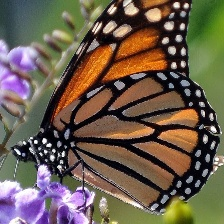

In [6]:
print(f"{test_ds[1][1]}.jpg")
test_ds[1][0]

### <u>Show the Images</u>

In [7]:
j = 0

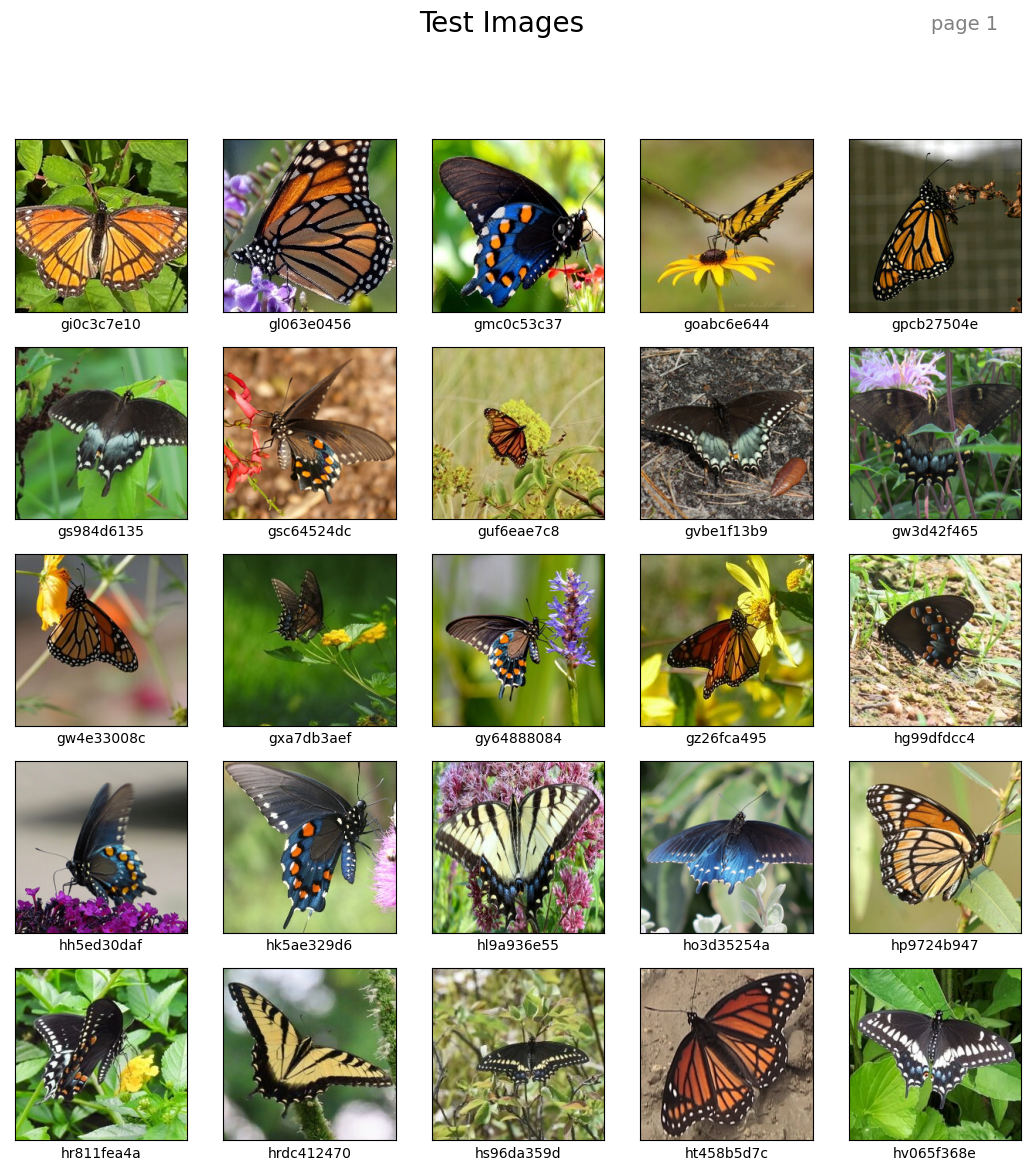

In [8]:
# Run this cell repeatedly to step through the images

rows = 5
cols = 5

plt.style.use("default")

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(13, 13))

plt.suptitle("Test Images\n", fontsize=20)

maxloop = len(test_ds)//(rows*cols)

if j <= maxloop:
    for i, ax in enumerate(axs.flat):
        k = (j*rows*cols) + i

        if k < len(test_ds):

            ax.grid(None)
            ax.axis('on')

            ax.imshow(test_ds[k][0], interpolation_stage='rgb')
            ax.set(xticks=[], yticks=[], xlabel = test_ds[k][1])
        else:
            ax.set_visible(False)

    fig.text(.83, .965, f"page {j+1}", color='grey', fontsize=14)


    j = j + 1 if j < maxloop else 0
    plt.show()

---